###Dataset###

##Import Dataset##

In [9]:
import pandas as pd

df = pd.read_csv('datasets\data.csv')
df.head()

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


##Map the dominant emotion to a numerical value##

In [13]:
emotion_columns = list(df.columns[3:])
emotion_to_num = {emotion: idx for idx, emotion in enumerate(emotion_columns)}

df['emotion'] = df[emotion_columns].idxmax(axis=1)  
df['emotion_num'] = df['emotion'].map(emotion_to_num)

df_cleaned = df.drop(columns=emotion_columns)
print(df_cleaned[['text', 'emotion', 'emotion_num']].head())

df_cleaned.to_csv('datasets/goemotions_cleaned.csv', index=False)

                                                text     emotion  emotion_num
0                                    That game hurt.     sadness           25
1   >sexuality shouldn’t be a grouping category I...  admiration            0
2     You do right, if you don't care then fuck 'em!     neutral           27
3                                 Man I love reddit.        love           18
4  [NAME] was nowhere near them, he was by the Fa...     neutral           27


In [ ]:
df['emotion'].value_counts()
# Note that the dataset is imbalanced, with the majority of the examples being labeled as "neutral".

emotion
neutral           55298
admiration        20542
approval          15530
annoyance         11929
disapproval        8917
amusement          8862
gratitude          8437
anger              7956
curiosity          7707
disappointment     6769
confusion          6600
love               5310
caring             5147
realization        5125
joy                5120
optimism           4994
excitement         4375
sadness            3863
surprise           3472
disgust            3420
desire             3002
fear               2514
embarrassment      1720
remorse            1648
nervousness         946
relief              814
pride               714
grief               494
Name: count, dtype: int64

###Training Model###

##Import library##

In [17]:
%pip install matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


##Split Train and Test data##

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['emotion_num'], test_size=0.2, random_state=42
)

##Tokenization Setup##

In [19]:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

##Text to Sequences & Label Encoding##

In [ ]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# One-hot encode labels
num_classes = df['emotion_num'].nunique()
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

##Building and Compiling Model##

In [22]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 28)                1820      
                                                                 
Total params: 1,421,660
Trainable params: 1,421,660
Non-trainable params: 0
_________________________________________________________________


##Model Training with Early Stopping##

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [24]:
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
2113/2113 [==============================] - 944s 445ms/step - loss: 2.5002 - accuracy: 0.3380 - val_loss: 2.2210 - val_accuracy: 0.3797
Epoch 2/20
2113/2113 [==============================] - 953s 451ms/step - loss: 2.2041 - accuracy: 0.3831 - val_loss: 2.1274 - val_accuracy: 0.3949
Epoch 3/20
2113/2113 [==============================] - 916s 434ms/step - loss: 2.1012 - accuracy: 0.3986 - val_loss: 2.0887 - val_accuracy: 0.4032
Epoch 4/20
2113/2113 [==============================] - 897s 425ms/step - loss: 2.0307 - accuracy: 0.4098 - val_loss: 2.0900 - val_accuracy: 0.4019
Epoch 5/20
2113/2113 [==============================] - 968s 458ms/step - loss: 1.9756 - accuracy: 0.4195 - val_loss: 2.0919 - val_accuracy: 0.4028
Epoch 6/20
2113/2113 [==============================] - 1082s 512ms/step - loss: 1.9272 - accuracy: 0.4285 - val_loss: 2.1009 - val_accuracy: 0.4021


##Evaluating Model##

In [25]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1321/1321 [==============================] - 59s 45ms/step - loss: 2.0841 - accuracy: 0.4035
Test Loss: 2.0841
Test Accuracy: 0.4035


##Plotting Accuracy and Loss Curves##

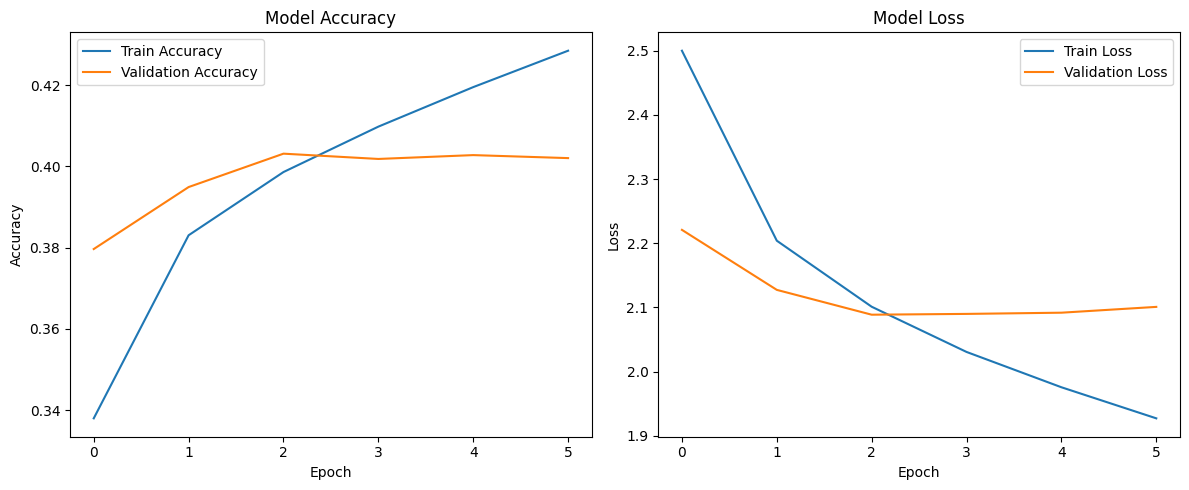

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('models/version 1/training_history.png')
plt.show()

##Confusion Matrix Visualization##

In [27]:
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.array(y_test)

1321/1321 [==============================] - 58s 44ms/step


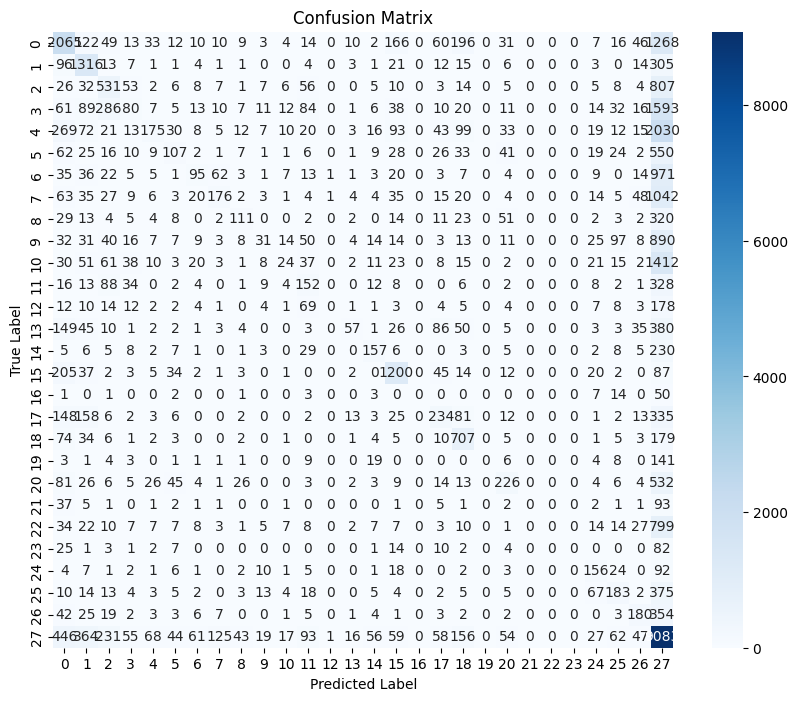

In [ ]:
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('models/version 1/confusion_matrix.png')
plt.show()

##Classification Report##

In [29]:
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      4146
           1       0.51      0.72      0.60      1824
           2       0.36      0.33      0.34      1596
           3       0.21      0.03      0.06      2406
           4       0.45      0.06      0.10      3005
           5       0.30      0.11      0.16       980
           6       0.33      0.07      0.12      1318
           7       0.42      0.11      0.18      1541
           8       0.44      0.18      0.26       606
           9       0.23      0.02      0.04      1327
          10       0.21      0.01      0.03      1797
          11       0.22      0.22      0.22       690
          12       0.00      0.00      0.00       345
          13       0.45      0.07      0.11       866
          14       0.45      0.33      0.38       483
          15       0.65      0.72      0.68      1675
          16       0.00      0.00      0.00        82
    

c:\Users\HP\.conda\envs\emo\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\.conda\envs\emo\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\.conda\envs\emo\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Emotion Label Mapping##

In [30]:
emotion_mapping = dict(zip(df['emotion_num'], df['emotion']))
print("Emotion Mapping:")
print(emotion_mapping)

Emotion Mapping:
{25: 'sadness', 0: 'admiration', 27: 'neutral', 18: 'love', 15: 'gratitude', 10: 'disapproval', 1: 'amusement', 9: 'disappointment', 22: 'realization', 3: 'annoyance', 6: 'confusion', 20: 'optimism', 7: 'curiosity', 13: 'excitement', 5: 'caring', 11: 'disgust', 24: 'remorse', 17: 'joy', 4: 'approval', 12: 'embarrassment', 26: 'surprise', 2: 'anger', 16: 'grief', 21: 'pride', 8: 'desire', 23: 'relief', 14: 'fear', 19: 'nervousness'}


##Saving Model and Tokenizer##

In [ ]:
model.save('models/version 1/emotion_prediction_model.h5')

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)